<a href="https://colab.research.google.com/github/srJboca/segmentacion/blob/main/3.%20Segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Segmentación de Clientes de Gas

## Introducción

Este notebook se enfoca en la segmentación de clientes utilizando el DataFrame `df_analisis.parquet`, que fue preparado en el notebook de exploración de datos. La segmentación de clientes nos permite agrupar clientes con características similares, lo cual es útil para estrategias de marketing personalizadas, gestión de servicios y optimización de operaciones.

**Objetivo:** Identificar distintos segmentos de clientes basados en su comportamiento de consumo y pago.

**Técnicas Utilizadas:**
1.  **Agregación de Datos:** Transformar datos a nivel de factura en características a nivel de cliente.
2.  **Análisis de Componentes Principales (PCA):** Reducir la dimensionalidad de los datos para facilitar la visualización y el clustering.
3.  **K-Means Clustering:** Agrupar los clientes en K segmentos distintos.
4.  **Perfilado de Segmentos:** Analizar las características de cada segmento.

## 1. Configuración del Entorno y Carga de Datos

### 1.1 Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 1.2 Descarga y Carga del DataFrame Preprocesado

Utilizaremos el archivo `df_analisis.parquet`.

In [2]:
!wget -N https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
df_analisis = pd.read_parquet('df_analisis.parquet')

--2025-05-30 21:05:39--  https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet [following]
--2025-05-30 21:05:40--  https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75105565 (72M) [application/octet-stream]
Saving to: ‘df_analisis.parquet’

df_analisis.parquet 100%[===================>]  71.63M   216MB/s    in 0.3s    

Last-modified header missing -- 

## 2. Revisión Rápida de Datos
Recordemos la estructura del DataFrame `df_analisis`.

In [3]:
print("--- Primeras 5 filas de df_analisis ---")
print(df_analisis.head())
print("\n--- Información de df_analisis ---")
df_analisis.info()

--- Primeras 5 filas de df_analisis ---
                      Numero de factura                    Numero de contrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
1  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
2  6848b692-4212-4738-a35c-1f8c0d383e3d  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   

  Fecha de Emision  Consumo (m3) Fecha de Pago Oportuno Fecha de Lectura  \
0       2021-01-06         11.51             2021-01-19       2020-12-28   
1       2021-01-06         11.51             2021-01-19       2020-12-28   
2       2021-03-02         10.26             2021-03-17       2021-02-20   
3       2021-04-01         14.96             2021-04-11       2021-03-27   
4       2021-05-10         14.89             2021-05-21       2021-05-05   

  Fecha de Suspe

## 3. Agregación de Características a Nivel de Cliente

Para segmentar clientes, necesitamos características que describan el comportamiento de cada cliente a lo largo del tiempo. Agruparemos los datos por `Numero de contrato` y calcularemos métricas agregadas (promedios) de su consumo, costos y comportamiento de pago.

El DataFrame `df_analisis` original (celda 4 del notebook proporcionado) contiene datos a nivel de factura. El notebook original también crea un `df_prediccion` (celda 6) que selecciona ciertas columnas, pero la agregación (celda 8) se realiza directamente sobre `df_analisis`. Seguiremos esta última lógica.

In [4]:
df_grouped = df_analisis.groupby('Numero de contrato').agg(
    Consumo_Promedio=('Consumo (m3)', 'mean'),
    Precio_Consumo_Promedio=('Precio por Consumo', 'mean'),
    Dias_Emision_PagoOportuno_Promedio=('Dias_Emision_PagoOportuno', 'mean'),
    Dias_Lectura_Emision_Promedio=('Dias_Lectura_Emision', 'mean'),
    Dias_PagoOportuno_PagoReal_Promedio=('Dias_PagoOportuno_PagoReal', 'mean'),
    Mora_Promedio=('Mora', 'mean') # Tasa de mora
).reset_index()

print("--- df_grouped (datos agregados por cliente) ---")
print(df_grouped.head())

--- df_grouped (datos agregados por cliente) ---
                     Numero de contrato  Consumo_Promedio  \
0  0002515b-27eb-4ed0-aeda-800b97757408         12.979375   
1  00031ba9-1077-41e5-9fa4-2cc1264c4120         12.043958   
2  00059def-f6c3-4bcd-9ef0-ddc0b5b98e7c         12.331250   
3  00065e0e-9e76-4553-93d4-d95657449c2a         11.794375   
4  00077b9d-e09e-4da6-a201-38621c36bc28         12.132708   

   Precio_Consumo_Promedio  Dias_Emision_PagoOportuno_Promedio  \
0             14186.484167                           12.645833   
1             13466.111667                           12.666667   
2             13503.808125                           12.541667   
3             15994.017708                           12.979167   
4             16402.697708                           12.375000   

   Dias_Lectura_Emision_Promedio  Dias_PagoOportuno_PagoReal_Promedio  \
0                       7.041667                            -1.500000   
1                       7.166667         

### 3.1 Incorporar 'Estrato Socioeconómico'

El 'Estrato socioeconomico' es una característica importante del cliente. Lo uniremos al DataFrame agrupado. Necesitamos obtener el estrato de `df_analisis` (o podríamos haberlo obtenido de `df_clientes` en la fase de exploración). Como `df_analisis` ya tiene 'Estrato', lo usaremos, asegurándonos de tomar un único valor por cliente.

In [5]:
# Obtener el estrato para cada contrato (tomando el primero, asumiendo que no cambia)
df_estratos = df_analisis.drop_duplicates(subset=['Numero de contrato'])[['Numero de contrato', 'Estrato']].copy()
# Renombrar 'Estrato' a 'Estrato socioeconomico' para claridad si es necesario
df_estratos.rename(columns={'Estrato': 'Estrato socioeconomico'}, inplace=True)

df_segmentacion = pd.merge(df_grouped, df_estratos, on='Numero de contrato', how='left')

print("--- df_segmentacion con Estrato ---")
print(df_segmentacion.head())
print("\n--- Información de df_segmentacion ---")
df_segmentacion.info()

--- df_segmentacion con Estrato ---
                     Numero de contrato  Consumo_Promedio  \
0  0002515b-27eb-4ed0-aeda-800b97757408         12.979375   
1  00031ba9-1077-41e5-9fa4-2cc1264c4120         12.043958   
2  00059def-f6c3-4bcd-9ef0-ddc0b5b98e7c         12.331250   
3  00065e0e-9e76-4553-93d4-d95657449c2a         11.794375   
4  00077b9d-e09e-4da6-a201-38621c36bc28         12.132708   

   Precio_Consumo_Promedio  Dias_Emision_PagoOportuno_Promedio  \
0             14186.484167                           12.645833   
1             13466.111667                           12.666667   
2             13503.808125                           12.541667   
3             15994.017708                           12.979167   
4             16402.697708                           12.375000   

   Dias_Lectura_Emision_Promedio  Dias_PagoOportuno_PagoReal_Promedio  \
0                       7.041667                            -1.500000   
1                       7.166667                      

## 4. Preprocesamiento para PCA y Clustering

### 4.1 Selección de Características Numéricas y Manejo de NaNs
Seleccionaremos las características numéricas para PCA y clustering. La columna 'Estrato socioeconomico' es categórica y la trataremos después o la usaremos para perfilar los segmentos. Por ahora, la convertiremos a numérica si es ordinal.
También eliminaremos filas con valores NaN en las características seleccionadas.

In [6]:
# Convertir 'Estrato socioeconomico' a numérico (ordinal)
if df_segmentacion['Estrato socioeconomico'].dtype == 'object' or isinstance(df_segmentacion['Estrato socioeconomico'].dtype, pd.CategoricalDtype):
    df_segmentacion['Estrato_Num'] = df_segmentacion['Estrato socioeconomico'].str.replace('Estrato ', '', regex=False).astype(int)
else:
    df_segmentacion['Estrato_Num'] = df_segmentacion['Estrato socioeconomico'].astype(int)

features_for_pca = [
    'Consumo_Promedio',
    'Precio_Consumo_Promedio',
    'Dias_Emision_PagoOportuno_Promedio',
    'Dias_Lectura_Emision_Promedio',
    'Dias_PagoOportuno_PagoReal_Promedio',
    'Mora_Promedio',
    'Estrato_Num' # Incluimos el estrato numérico
]
X = df_segmentacion[features_for_pca].copy()

print(f"Shape antes de dropna: {X.shape}")
X.dropna(inplace=True) # Eliminar filas con NaNs en estas características
print(f"Shape después de dropna: {X.shape}")

print("\nValores faltantes después de dropna:")
print(X.isnull().sum())

Shape antes de dropna: (50000, 7)
Shape después de dropna: (50000, 7)

Valores faltantes después de dropna:
Consumo_Promedio                       0
Precio_Consumo_Promedio                0
Dias_Emision_PagoOportuno_Promedio     0
Dias_Lectura_Emision_Promedio          0
Dias_PagoOportuno_PagoReal_Promedio    0
Mora_Promedio                          0
Estrato_Num                            0
dtype: int64


### 4.2 Escalado de Características
PCA es sensible a la escala de las características. Por lo tanto, estandarizaremos los datos.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("--- Datos escalados (primeras 5 filas) ---")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

--- Datos escalados (primeras 5 filas) ---
   Consumo_Promedio  Precio_Consumo_Promedio  \
0          0.732802                -0.486200   
1         -0.699988                -0.662735   
2         -0.259940                -0.653497   
3         -1.082279                -0.043244   
4         -0.564049                 0.056908   

   Dias_Emision_PagoOportuno_Promedio  Dias_Lectura_Emision_Promedio  \
0                            0.576942                      -1.784536   
1                            0.658225                      -1.296144   
2                            0.170532                      -0.400760   
3                            1.877457                       0.087632   
4                           -0.479726                       0.576024   

   Dias_PagoOportuno_PagoReal_Promedio  Mora_Promedio  Estrato_Num  
0                            -2.015522      -1.278841    -1.173305  
1                            -1.093100      -1.278841    -0.319558  
2                           

## 5. Análisis de Componentes Principales (PCA)

Reduciremos la dimensionalidad a 2 componentes principales para visualización.

In [8]:
pca = PCA(n_components=2) # Reducir a 2 componentes
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['principal_component_1', 'principal_component_2'])

print("--- Componentes Principales (primeras 5 filas) ---")
print(df_pca.head())

print(f"\nVarianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza explicada total (2 componentes): {pca.explained_variance_ratio_.sum():.2f}")

--- Componentes Principales (primeras 5 filas) ---
   principal_component_1  principal_component_2
0              -0.896595              -2.373121
1              -0.686935              -1.710830
2              -1.316098               0.026509
3               0.102506               1.128067
4               0.264357               0.969185

Varianza explicada por cada componente: [0.27494557 0.24993022]
Varianza explicada total (2 componentes): 0.52


La varianza explicada total nos dice qué porcentaje de la información original se retiene en los 2 componentes principales.

## 6. K-Means Clustering

### 6.1 Método del Codo para K Óptimo
Usaremos el método del codo para ayudar a determinar un número apropiado de clusters (K). Buscamos el punto donde añadir más clusters no mejora significativamente la suma de los errores cuadráticos (SSE) o inercia.

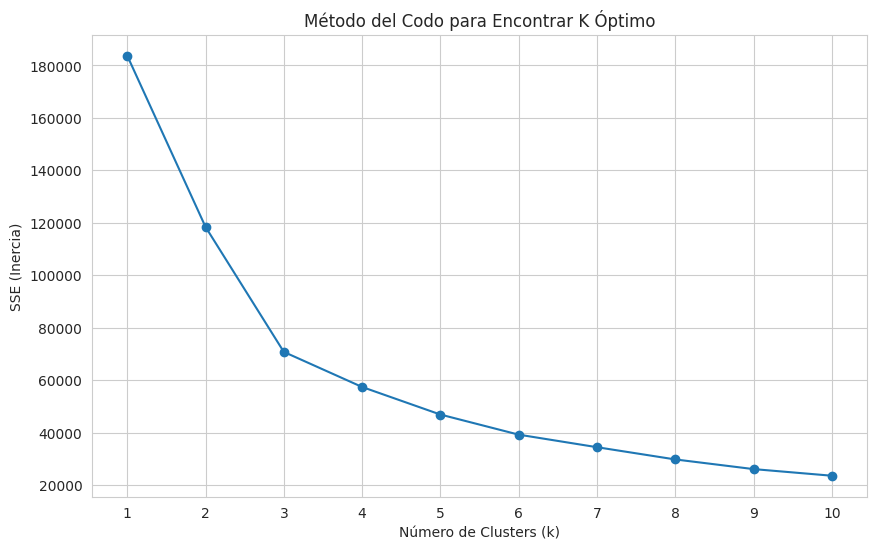

In [9]:
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' es el valor por defecto en versiones recientes
    kmeans.fit(df_pca) # Usamos los datos transformados por PCA
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE (Inercia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Observa el gráfico anterior. El "codo" es el punto donde la tasa de disminución de SSE se aplana. Este punto sugiere un valor K óptimo. Para este tutorial, basándonos en el notebook original, usaremos K=4. (En un caso real, seleccionarías K basado en la visualización del codo).

### 6.2 Aplicación de K-Means y Visualización
Aplicamos K-Means con el K óptimo (K=4) y visualizamos los clusters en el espacio de PCA.

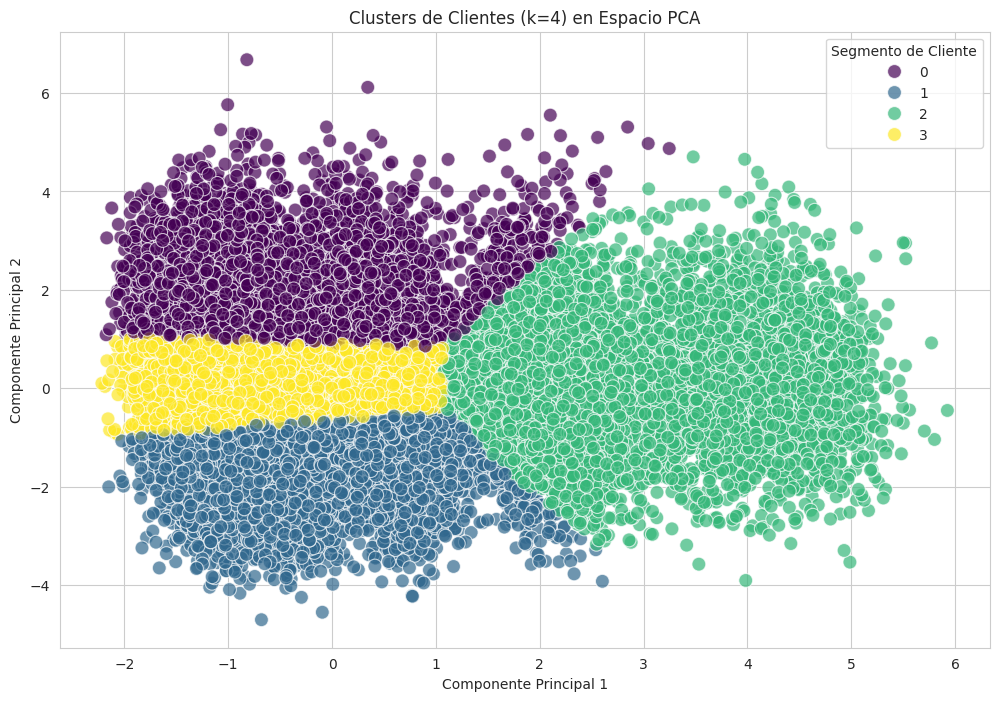

--- df_pca con Segmentos ---
   principal_component_1  principal_component_2  segmento
0              -0.896595              -2.373121         1
1              -0.686935              -1.710830         1
2              -1.316098               0.026509         3
3               0.102506               1.128067         0
4               0.264357               0.969185         0


In [10]:
optimal_k = 4 # @param {type:"integer"} # Elegido del método del codo o análisis de negocio

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_pca['segmento'] = kmeans_optimal.fit_predict(df_pca)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='principal_component_1', y='principal_component_2', hue='segmento', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title(f'Clusters de Clientes (k={optimal_k}) en Espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Segmento de Cliente')
plt.grid(True)
plt.show()

print("--- df_pca con Segmentos ---")
print(df_pca.head())

## 7. Perfilado de Segmentos

Ahora que tenemos los segmentos, necesitamos entender qué caracteriza a cada uno. Uniremos las etiquetas de segmento de nuevo al DataFrame `df_segmentacion` (que contiene las características agregadas y el estrato) y analizaremos las medias de las características para cada segmento.

In [13]:
# X fue X.dropna(), así que df_pca debería tener la misma longitud y orden
# Creamos df_segmentacion_cleaned para asegurar la correspondencia de índices
df_segmentacion_cleaned = df_segmentacion.loc[X.index].copy()
df_segmentacion_cleaned['segmento'] = df_pca['segmento'].values

print("--- df_segmentacion_cleaned con Segmentos ---")
print(df_segmentacion_cleaned.head())

--- df_segmentacion_cleaned con Segmentos ---
                     Numero de contrato  Consumo_Promedio  \
0  0002515b-27eb-4ed0-aeda-800b97757408         12.979375   
1  00031ba9-1077-41e5-9fa4-2cc1264c4120         12.043958   
2  00059def-f6c3-4bcd-9ef0-ddc0b5b98e7c         12.331250   
3  00065e0e-9e76-4553-93d4-d95657449c2a         11.794375   
4  00077b9d-e09e-4da6-a201-38621c36bc28         12.132708   

   Precio_Consumo_Promedio  Dias_Emision_PagoOportuno_Promedio  \
0             14186.484167                           12.645833   
1             13466.111667                           12.666667   
2             13503.808125                           12.541667   
3             15994.017708                           12.979167   
4             16402.697708                           12.375000   

   Dias_Lectura_Emision_Promedio  Dias_PagoOportuno_PagoReal_Promedio  \
0                       7.041667                            -1.500000   
1                       7.166667            

### 7.1 Características Promedio por Segmento

--- Perfiles de Segmentos (Características Promedio) ---
          Consumo_Promedio  Precio_Consumo_Promedio  \
segmento                                              
0                12.507878             15029.937120   
1                12.504786             14835.776436   
2                12.573909             24653.506021   
3                12.467332             14490.595034   

          Dias_Emision_PagoOportuno_Promedio  Dias_Lectura_Emision_Promedio  \
segmento                                                                      
0                                  12.498508                       7.496459   
1                                  12.497406                       7.502133   
2                                  12.495209                       7.498953   
3                                  12.499094                       7.496600   

          Dias_PagoOportuno_PagoReal_Promedio  Mora_Promedio  Estrato_Num  
segmento                                                     

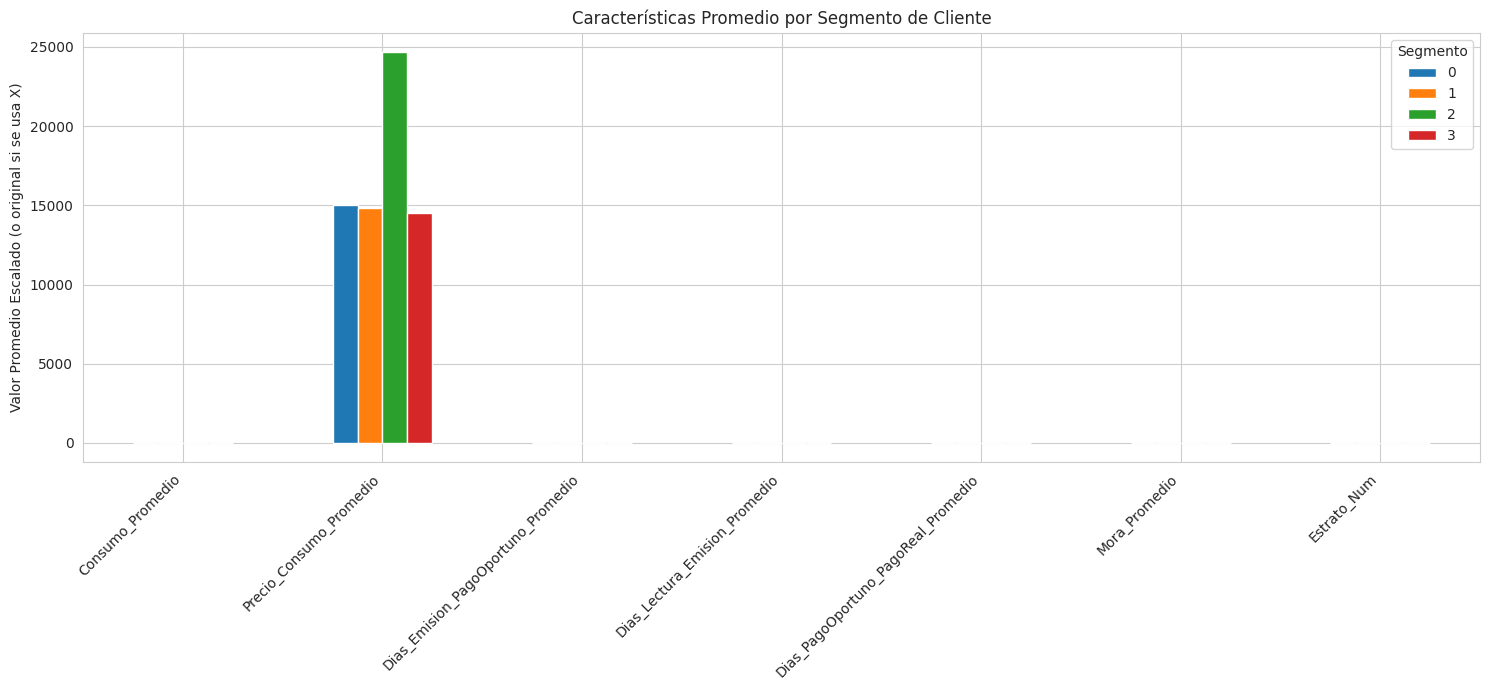

In [14]:
segment_profiles = df_segmentacion_cleaned.groupby('segmento')[features_for_pca].mean()
print("--- Perfiles de Segmentos (Características Promedio) ---")
print(segment_profiles)

# Visualización de los perfiles
segment_profiles.T.plot(kind='bar', figsize=(15, 7))
plt.title('Características Promedio por Segmento de Cliente')
plt.ylabel('Valor Promedio Escalado (o original si se usa X)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Segmento')
plt.tight_layout()
plt.show()

### 7.2 Distribución de Estrato por Segmento


--- Distribución Porcentual de Estrato por Segmento ---
Estrato socioeconomico  Estrato 1  Estrato 2  Estrato 3  Estrato 4  Estrato 5  \
segmento                                                                        
0                       26.305140  38.617968  32.335087   2.701335   0.040469   
1                       26.920220  40.551181  31.525776   1.002823   0.000000   
2                        0.000000   0.000000   2.993272  63.256900  17.163257   
3                       31.996283  42.894017  25.094213   0.015487   0.000000   

Estrato socioeconomico  Estrato 6  
segmento                           
0                        0.000000  
1                        0.000000  
2                       16.586571  
3                        0.000000  


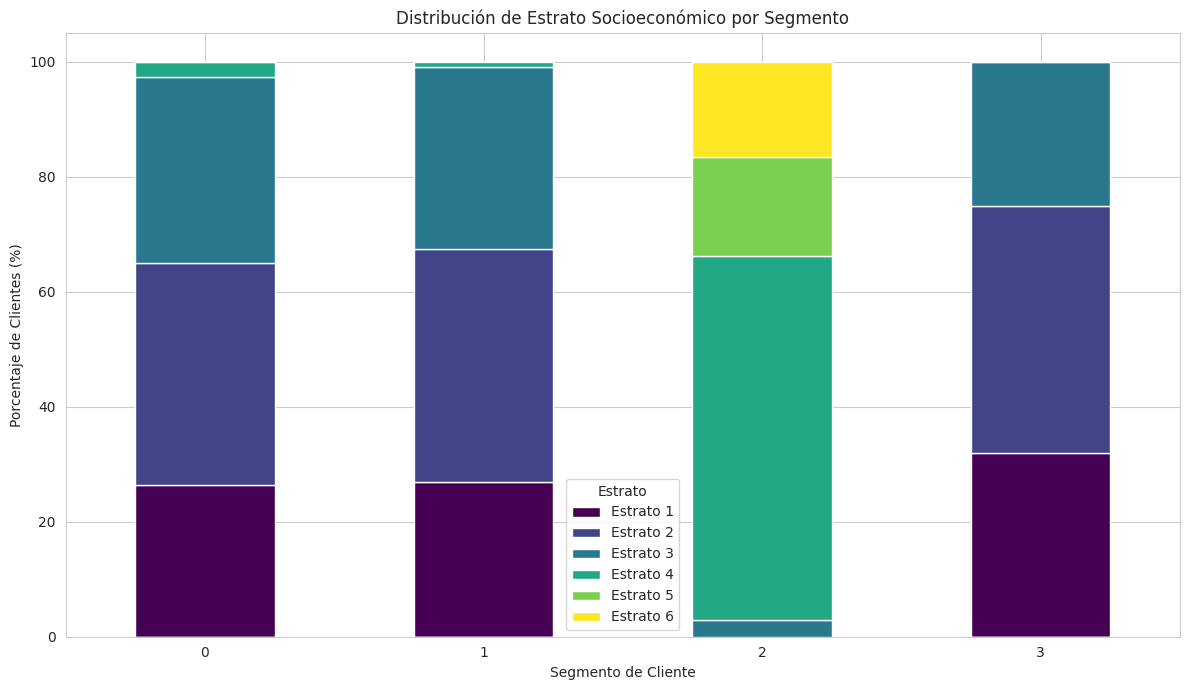

In [15]:
estrato_segment_distribution = pd.crosstab(df_segmentacion_cleaned['segmento'], df_segmentacion_cleaned['Estrato socioeconomico'], normalize='index') * 100
print("\n--- Distribución Porcentual de Estrato por Segmento ---")
print(estrato_segment_distribution)

estrato_segment_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Distribución de Estrato Socioeconómico por Segmento')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Porcentaje de Clientes (%)')
plt.xticks(rotation=0)
plt.legend(title='Estrato')
plt.tight_layout()
plt.show()

**Interpretación de Perfiles:**
* **Características Promedio:** Observa las barras para cada segmento. ¿Qué características tienen valores altos o bajos en un segmento particular? Por ejemplo, un segmento podría tener un 'Consumo_Promedio' alto y una 'Mora_Promedio' baja, indicando clientes de alto valor y buen comportamiento de pago.
* **Distribución de Estrato:** ¿Hay algún estrato predominante en cada segmento? Esto puede ayudar a entender la composición socioeconómica de los grupos.

**Nombrando los Segmentos (Ejemplo):**
Basado en el análisis, podrías asignar nombres descriptivos a cada segmento, como:
* **Segmento 0:** Clientes de Bajo Consumo, Pago Puntual
* **Segmento 1:** Clientes de Alto Consumo, Morosidad Moderada, Estrato Alto
* Etc.

## 8. Conclusiones y Próximos Pasos

En este notebook, hemos:
1.  Agregado los datos a nivel de cliente.
2.  Utilizado PCA para reducir la dimensionalidad y facilitar la visualización.
3.  Aplicado K-Means para agrupar a los clientes en segmentos (K=4 en este ejemplo).
4.  Iniciado el perfilado de los segmentos analizando sus características promedio y la distribución de estratos.

**Próximos Pasos Potenciales:**
* **Validación de Segmentos:** Utilizar métricas de clustering (como el Coeficiente de Silueta) para evaluar la calidad de los segmentos. También, validar la estabilidad de los segmentos con diferentes inicializaciones de K-Means o subconjuntos de datos.
* **Perfilado Detallado:** Analizar más variables para cada segmento (e.g., antigüedad del cliente, tipo de contrato, si se incluyeran).
* **Acciones Estratégicas:** Definir estrategias específicas para cada segmento (e.g., campañas de fidelización para clientes de alto valor, programas de gestión de mora para segmentos con alta tasa de impago, ofertas personalizadas según el consumo).
* **Monitoreo:** Observar cómo evolucionan los segmentos con el tiempo y si los clientes cambian de un segmento a otro.
* **Probar otros algoritmos:** Explorar otros algoritmos de clustering (e.g., DBSCAN, Aglomerativo) si K-Means no produce resultados satisfactorios o si se sospecha de estructuras de clusters no esféricas.

La segmentación de clientes es una herramienta poderosa para entender mejor la base de clientes y tomar decisiones de negocio más informadas.